In [116]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import get_data
from numba import jit
from typing import Optional, Union, List
from indicators import get_ATR

In [117]:
df = get_data('NQ')
df = df.loc['20180901': '20190331']

(200265, 2)

In [522]:
@jit(nopython=True)
def _swing(data: np.array, f: np.array, margin: np.array) -> np.array:
    state = np.ones((data.shape[0], 1), dtype=np.int8)
    extreme = np.zeros(state.shape)
    extreme[0] = data[0,0]
    pivot = np.zeros(state.shape)
    pivot[0] = data[0, 0]
    signal = np.ones(state.shape, dtype=np.int8)
    signal[0] = 1
    max_pivot = np.array([data[0, 0]])
    min_pivot = np.array([data[0, 1]])
    max_list = np.zeros(state.shape)
    min_list = np.zeros(state.shape)

    for i, row in enumerate(data):
        #print(f'{i} row: {row}, extreme: {extreme[i-1]}')
        if i == 0:
            continue          

        if state[i-1, 0] == 1:   
            if (row[0] > (max_pivot[0] + margin[i])): 
                signal[i] = 1
            else:
                signal[i] = signal[i-1]
                
            if (extreme[i-1, 0] - row[1]) > f[i]:
                state[i] = -1
                extreme[i] = row[1]
                pivot[i] = extreme[i-1]
                max_pivot = pivot[i]
                max_list[i] = max_pivot
            else:
                state[i] = 1
                extreme[i] = max(extreme[i-1, 0], row[0])
                pivot[i] = pivot[i-1]
            
        elif state[i-1, 0] == -1:  
            if (row[1] < (min_pivot[0] - margin[i])):
                signal[i] = -1
            else:
                signal[i] =signal[i-1]
                
            if np.abs(extreme[i-1, 0] - row[0]) > f[i]:
                state[i] = 1
                extreme[i] = row[0]
                pivot[i] = extreme[i-1]
                min_pivot = pivot[i]
                min_list[i] = min_pivot
            else:
                state[i, 0] = -1
                extreme[i] = min(extreme[i-1, 0], row[1])
                pivot[i] = pivot[i-1]
            
            
        else:
            raise ValueError('Wrong state value!')
        #print(f'pivot: {pivot[i]}, extreme: {extreme[i]}, signal: {signal[i]}, state: {state[i,0]}')
        #print(f'min_pivot: {min_pivot}, max_pivot: {max_pivot}')      
        #print('---------------')
    return np.concatenate((state, extreme, pivot, signal, max_list, min_list), axis=1)

In [675]:
def swing(data: pd.DataFrame, f: Union[float, np.array], margin: Optional[float] = None) -> np.array:
    if isinstance(f, (float, int)):
        f = np.ones((data.shape[0], 1)) * f
    elif isinstance(f, (pd.DataFrame, pd.Series)):
        f = f.to_numpy()
    if margin:
        if isinstance(margin, (pd.DataFrame, pd.Series)):
            margin = margin.to_numpy()
        margin = margin * f
    else:
        margin = 0 * f
    data = data[['high', 'low']].to_numpy()
    return _swing(data, f, margin)

# Plain Swing for Various f Values

f=75

In [567]:
df3 = df.copy()
df3[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing(df3, 75)
df3[['max_list', 'min_list']] = df3[['max_list', 'min_list']].replace(0.0, np.nan)
df3[['max_list', 'min_list']] = df3[['max_list', 'min_list']].fillna(method='ffill')
df3

,open,high,low,close,volume,average,barCount,swing,extreme,pivot,signal,max_list,min_list
date,,,,,,,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26,1.0,7675.0,7675.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58,1.0,7414.5,7276.0,-1.0,7447.5,7276.0
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52,1.0,7414.5,7276.0,-1.0,7447.5,7276.0
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47,1.0,7414.5,7276.0,-1.0,7447.5,7276.0


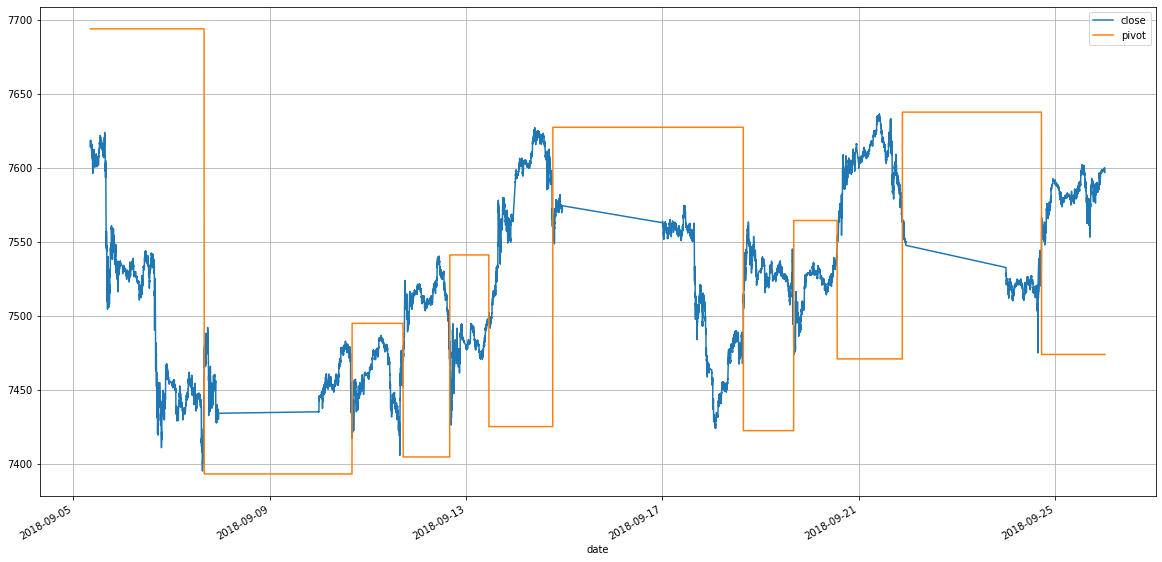

In [568]:
t = df3.iloc[3000:23000]
t[['close', 'pivot']].plot(figsize=(20,10), grid=True);

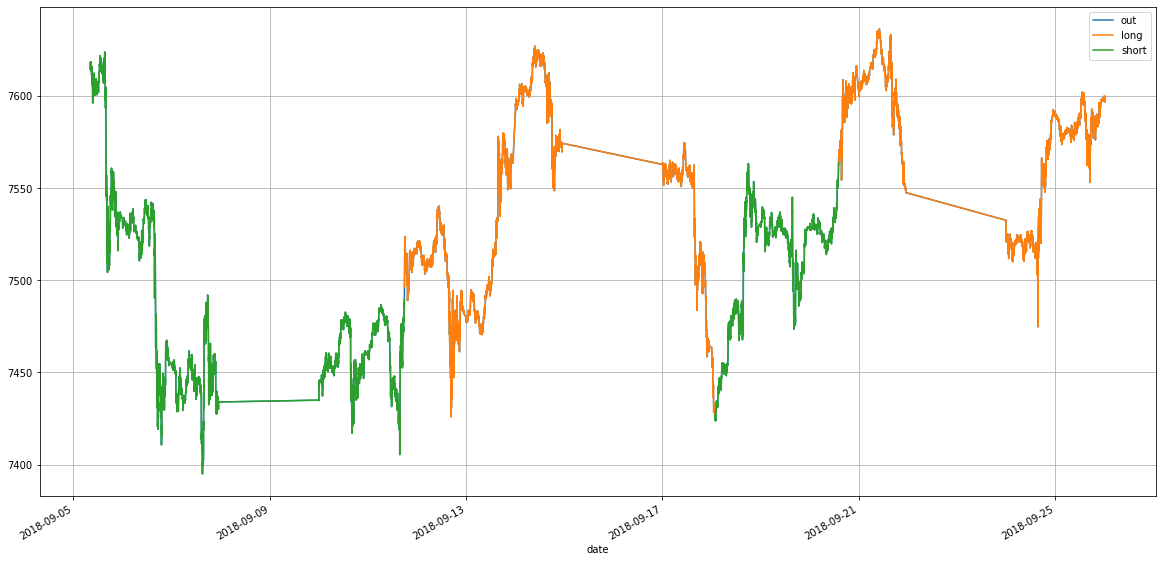

In [569]:
chart_price(t['close'], t['signal']);

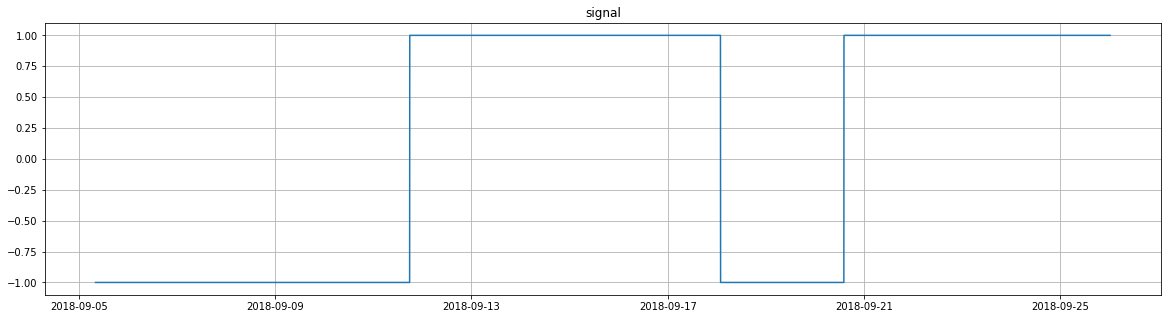

In [570]:
plot(t.signal);

In [571]:
def swing_chart_data(df: pd.DataFrame, keep_columns: Optional[Union[List, str]] = None) -> pd.DataFrame:
    df = df.copy()
    df['swing_point'] = (df['swing'] != df['swing'].shift()) * 1
    df['swing_price'] = df['swing_point'] * df['extreme'].shift().fillna(method='bfill')
    df['close_price'] = df['swing_point'] * df['close']
    output_columns = ['swing_price', 'close_price']
    if keep_columns:
        if isinstance(keep_columns, str):
            keep_columns = [keep_columns]
        output_columns.extend(keep_columns)
    swing_df = df[df['swing_price'] != 0].loc[:, output_columns]
    swing_df.reset_index(drop=True, inplace=True)
    return swing_df

In [572]:
swing_chart = swing_chart_data(t)
swing_chart

,swing_price,close_price
0,7586.75,7618.00
1,7393.00,7474.25
2,7494.75,7418.25
3,7404.50,7479.50
4,7541.00,7466.00
5,7425.00,7502.00
6,7627.25,7551.75
7,7422.25,7494.25
8,7564.25,7484.75
9,7470.75,7545.50


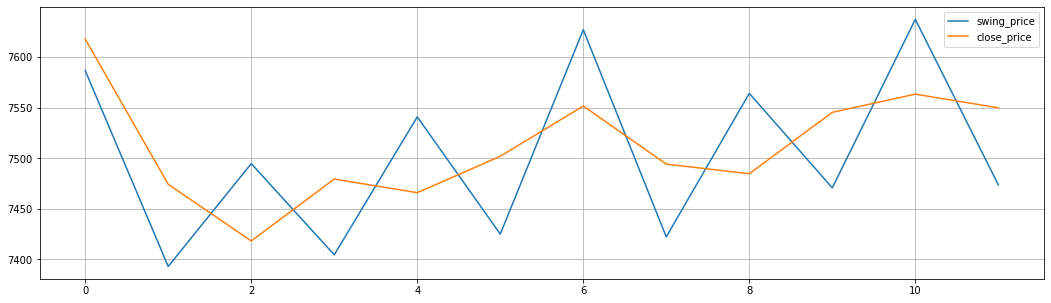

In [573]:
swing_chart.plot(figsize=(18,5), grid=True, secondary_y='signal');

In [574]:
def sim(price, indicator, slip=1.5, threshold=0):
    b = v_backtester(price, indicator, threshold)
    r = perf_var(b, False, slippage=slip)
    return r.stats, r.daily['returns']

In [575]:
out = sim(t['close'], t['signal'])
out[0]

Annual return                 -0.148074
Cumulative returns           -0.0101234
Annual volatility              0.135681
Sharpe ratio                    -1.1169
Calmar ratio                   -3.60334
Stability                      0.679543
Max drawdown                 -0.0410936
Omega ratio                    0.821237
Sortino ratio                  -1.43825
Skew                          -0.575655
Kurtosis                     -0.0400198
Tail ratio                     0.686112
Daily value at risk          -0.0176955
Win percent                         0.5
Average gain                         74
Average loss                   -109.125
Avg gain/loss ratio            0.678121
Position EV                    -17.5625
Positions per day                  0.25
Days per position                     4
Actual avg. duration    5 days 04:01:00
Days                                 16
Positions                             4
Trades                                7
Monthly EV                     -92.2031


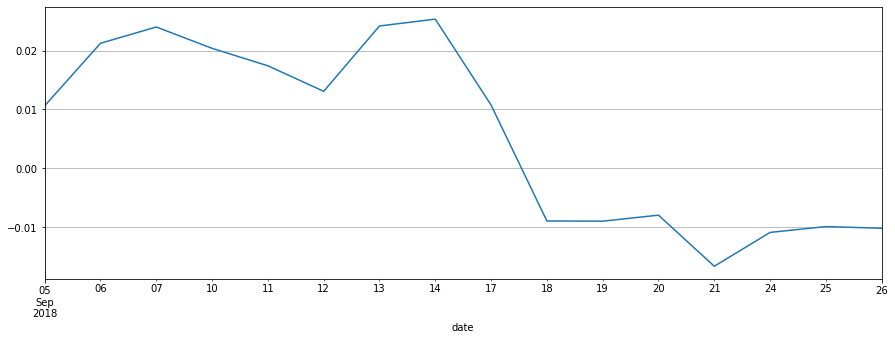

In [576]:
np.log(out[1]+1).cumsum().plot(figsize=(15, 5), grid=True);

# Combining Two Swings

In [577]:
f = [i for i in range(20, 320, 20)]
df4 = df.copy()
for i in f:
    df4[i] = swing(df4, i)[:,3]

In [578]:
def stats(df, f):
    results = pd.DataFrame()
    for i in f:
        try:
            results[i] = sim(df4['close'], df[i])[0]
        except:
            continue
    return results

In [579]:
stats(df4[3000:], f)

,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300
Annual return,-0.32037,-0.172229,0.0492967,0.0487007,0.0282447,-0.194145,0.0808511,-0.216486,-0.236029,-0.166214,-0.139992,0.159113,0.197013,-0.188821,0.0233076
Cumulative returns,-0.202936,-0.105071,0.0286642,0.028321,0.0164928,-0.119064,0.0467206,-0.13349,-0.14625,-0.101258,-0.0847635,0.0905889,0.111393,-0.11565,0.0136235
Annual volatility,0.23717,0.2386,0.237234,0.225865,0.220435,0.242424,0.221715,0.238747,0.237032,0.238247,0.244345,0.240974,0.24224,0.243194,0.242411
Sharpe ratio,-1.50771,-0.672555,0.320646,0.322827,0.23627,-0.769301,0.460309,-0.90254,-1.01728,-0.644248,-0.495448,0.732416,0.862762,-0.739323,0.215354
Calmar ratio,-0.968433,-0.725325,0.339137,0.480148,0.288584,-1.0302,0.607027,-0.812434,-0.885249,-0.739573,-0.675086,1.28292,1.68911,-0.990065,0.159022
Stability,0.63882,0.507942,0.148445,0.210007,0.354664,0.602429,0.206173,0.592178,0.608643,0.526542,0.424858,0.608816,0.633841,0.558536,0.194876
Max drawdown,-0.330813,-0.237452,-0.145359,-0.101429,-0.0978735,-0.188454,-0.133192,-0.266467,-0.266624,-0.224743,-0.207369,-0.124023,-0.116637,-0.190716,-0.146568
Omega ratio,0.766871,0.887404,1.05918,1.05891,1.04397,0.867622,1.08576,0.848527,0.831263,0.88893,0.913755,1.14183,1.16853,0.873876,1.03996
Sortino ratio,-1.84023,-0.896272,0.465366,0.457867,0.323793,-1.04043,0.7066,-1.21776,-1.3748,-0.891629,-0.683331,1.11744,1.31923,-1.03556,0.318646
Skew,-1.17767,-0.590572,0.0411017,-0.082681,-0.403194,-0.120008,0.515077,-0.0749622,-0.0270327,0.000208868,-0.0825583,0.136754,0.110011,0.098913,0.106805


In [580]:
def combine(df, n):
    out = pd.DataFrame()
    out['close'] = df['close']
    for i in f:
        if i == n:
            continue
        out[i] = (df[i] + df[n]).clip(-1, 1)
    return out

In [581]:
stats(combine(df4[3000:], 120), f)

,20,40,60,80,100,140,160,180,200,220,240,260,280,300
Annual return,-0.250114,-0.173343,-0.072052,-0.0742189,-0.0868279,-0.0644049,-0.200797,-0.210734,-0.175278,-0.161875,-0.0255298,-0.00825674,-0.181637,-0.081085
Cumulative returns,-0.155529,-0.105778,-0.0429677,-0.0442809,-0.0519472,-0.0383437,-0.123342,-0.12976,-0.107009,-0.0985134,-0.0150736,-0.00485749,-0.111059,-0.0484502
Annual volatility,0.179676,0.17476,0.191121,0.198683,0.217692,0.217285,0.210892,0.208999,0.208392,0.204067,0.191025,0.186134,0.184296,0.174578
Sharpe ratio,-1.51127,-1.00235,-0.296289,-0.289263,-0.308777,-0.198808,-0.957708,-1.02812,-0.821025,-0.763848,-0.0409165,0.0473422,-0.996127,-0.398106
Calmar ratio,-1.08193,-0.93506,-0.601889,-0.787509,-0.68937,-0.481721,-0.957174,-1.00414,-0.909476,-0.839929,-0.220812,-0.0880369,-1.15825,-0.663302
Stability,0.682995,0.58082,0.151435,0.320576,0.203372,0.16714,0.676039,0.691249,0.622398,0.557778,0.00799889,0.0378325,0.70418,0.217107
Max drawdown,-0.231175,-0.185381,-0.11971,-0.0942452,-0.125953,-0.133697,-0.209781,-0.209866,-0.192724,-0.192724,-0.115618,-0.0937873,-0.156819,-0.122244
Omega ratio,0.757931,0.82791,0.944046,0.947274,0.943125,0.963365,0.83077,0.819005,0.852197,0.856947,0.991515,1.00998,0.800899,0.911838
Sortino ratio,-1.95742,-1.4623,-0.422606,-0.408931,-0.42571,-0.290862,-1.30853,-1.40854,-1.13283,-1.06275,-0.061107,0.0727087,-1.43187,-0.597494
Skew,-0.598701,0.546594,0.0793433,-0.101479,-0.198406,0.451505,0.250437,0.30158,0.278395,0.312769,0.606487,0.827263,0.780742,0.918662


# Combine Swing with Plain Direction

First value is f for swing, second for direction.

In [582]:
df5 = df.copy()
for i in f:
    df5[i] = swing(df5, i)[:,0]

In [583]:
def combine_swing_direction(df1, df2, n, m):
    out = pd.DataFrame()
    out['close'] = df['close']
    out[n] = df1[n]
    out[m] = df2[m]
    out['combined'] = (df1[n] + df2[m]).clip(-1, 1)
    return out

In [584]:
stats(combine_swing_direction(df4, df5, 240, 80)[3000:], ['combined'])

,combined
Annual return,0.0963645
Cumulative returns,0.0555179
Annual volatility,0.177265
Sharpe ratio,0.606211
Calmar ratio,1.12859
Stability,0.264206
Max drawdown,-0.0853851
Omega ratio,1.11977
Sortino ratio,1.08314
Skew,1.3921


In [585]:
def plot_swing(df: pd.DataFrame, f: Union[float, np.array]) -> None:
    df = df.copy()
    df[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing(df, f)
    df = df.iloc[3000:]
    swing_chart = swing_chart_data(df)
    swing_chart.plot(figsize=(18,5), grid=True, secondary_y='signal');

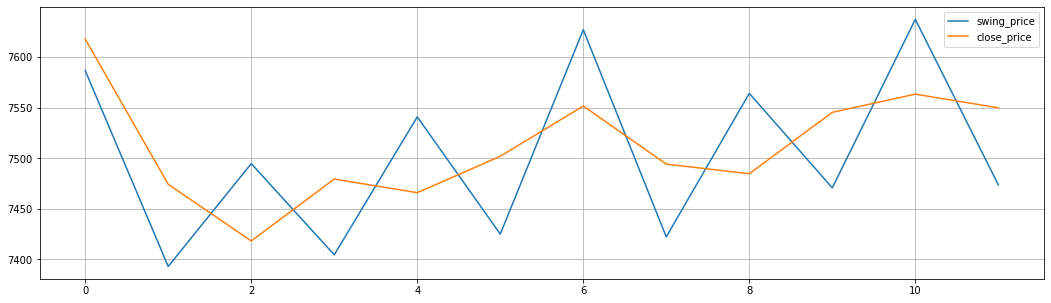

In [586]:
plot_swing(df.iloc[:23000], 75)

In [587]:
def time_indexed_swing_chart_data(df: pd.DataFrame, f: Union[float, np.array]) -> pd.DataFrame:
    df = df.copy()
    df[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = atr_swing(df, f)
    df = df.iloc[3000:]
    df['swing_point'] = (df['swing'] != df['swing'].shift()) * 1
    df['swing_price'] = df['swing_point'] * df['extreme'].shift().fillna(method='bfill')
    df['close_price'] = df['swing_point'] * df['close']  
    swing_df = df[df['swing_price'] != 0].loc[:, ['swing_price', 'close_price']]
    #swing_df.reset_index(drop=True, inplace=True)
    return swing_df

In [588]:
def multiple_swing_data(df: pd.DataFrame, f: List[Union[float, np.array]]) -> pd.DataFrame:
    out = pd.DataFrame()
    out['close_price'] = df['close']
    for i in f:
        out[i] = time_indexed_swing_chart_data(df, i)['swing_price']
    return out.iloc[3000:]

In [589]:
def plot_multiple_swing(df: pd.DataFrame, f: List[Union[float, np.array]]) -> None:
    multiple_swing_data(df, f).fillna(method='ffill').plot(figsize=(15,5), grid=True)

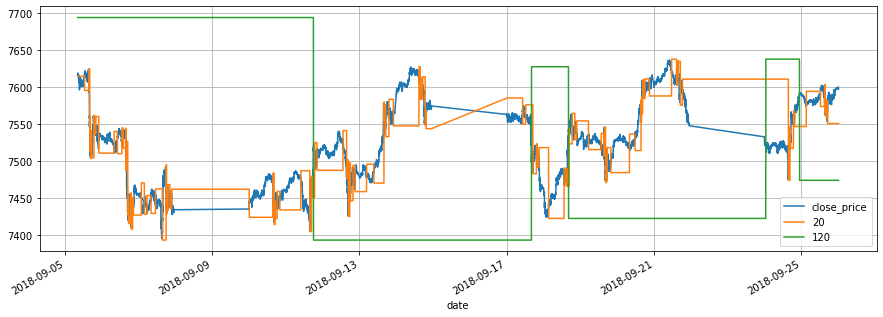

In [590]:
plot_multiple_swing(df.iloc[:23000], [20, 120]);

In [591]:
def plot_multiple_swing_rescaled(df: pd.DataFrame, f: List[Union[float, np.array]]) -> None:
    df = multiple_swing_data(df, f)
    i, j = df.columns.drop('close_price')
    df[df[i].notna() | df[j].notna()].interpolate().reset_index(drop=True).plot(figsize=(15,5), grid=True);

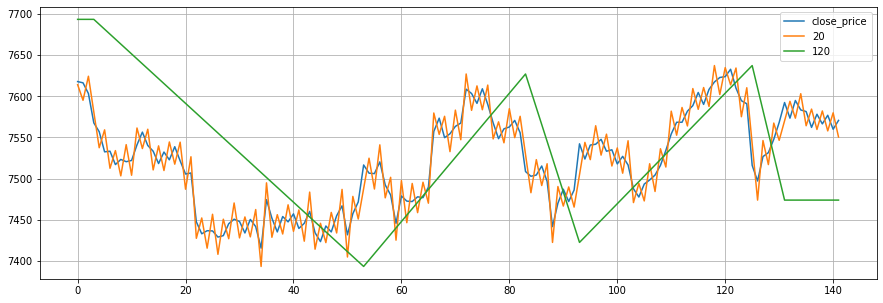

In [592]:
plot_multiple_swing_rescaled(df[:23000], [20, 120]);

In [593]:
t = combine_swing_direction(df4, df5, 20, 120)[:23000]
t

,close,20,120,combined
date,,,,
2018-09-03 00:00:00,7671.50,1.0,1.0,1.0
2018-09-03 00:01:00,7670.00,1.0,1.0,1.0
2018-09-03 00:02:00,7671.00,1.0,1.0,1.0
2018-09-03 00:03:00,7671.75,1.0,1.0,1.0
2018-09-03 00:04:00,7669.75,1.0,1.0,1.0
...,...,...,...,...
2018-09-26 00:15:00,7598.50,1.0,1.0,1.0
2018-09-26 00:16:00,7598.25,1.0,1.0,1.0
2018-09-26 00:17:00,7598.25,1.0,1.0,1.0


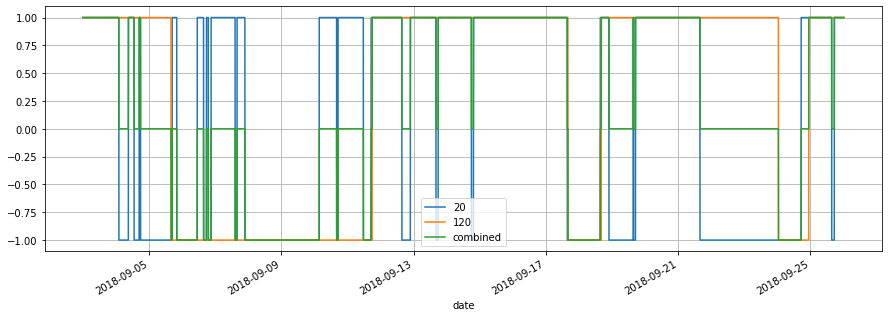

In [594]:
t[[20, 120, 'combined']].plot(figsize=(15, 5), grid=True);

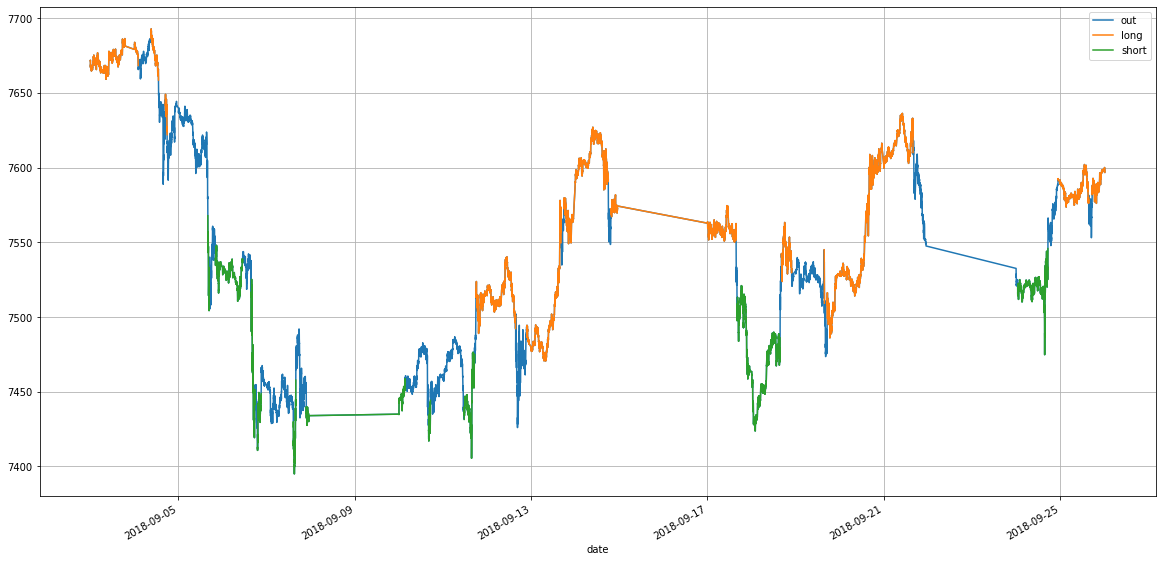

In [595]:
chart_price(t['close'], t['combined']);

# Multiple swing signals

In [596]:
df6 = df4.copy()
df6.drop(['close', 'open', 'high', 'low', 'volume', 'average', 'barCount'], axis=1, inplace=True)
df6 = df6[[40, 80, 120, 160, 200, 240, 300]]

In [597]:
df6['combined'] = df6.sum(axis=1)
df6

,40,80,120,160,200,240,300,combined
date,,,,,,,,
2018-09-03 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
2018-09-03 00:01:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
2018-09-03 00:02:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
2018-09-03 00:03:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
2018-09-03 00:04:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,3.0
2019-03-29 21:56:00,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,3.0
2019-03-29 21:57:00,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,3.0


In [598]:
summary(df5['close'], df6['combined'], slip=1.5, threshold=range(20)).stats

,0,1,2,3,4,5,6
Annual return,-0.139588,0.0242893,0.0242893,-0.0600709,-0.0600709,-0.170051,-0.170051
Cumulative returns,-0.0845115,0.0141944,0.0141944,-0.0357299,-0.0357299,-0.103689,-0.103689
Annual volatility,0.245956,0.20808,0.20808,0.154945,0.154945,0.104384,0.104384
Sharpe ratio,-0.488437,0.218353,0.218353,-0.323602,-0.323602,-1.73321,-1.73321
Calmar ratio,-0.793207,0.210663,0.210663,-0.556546,-0.556546,-1.46663,-1.46663
Stability,0.583235,0.0120106,0.0120106,0.320046,0.320046,0.854121,0.854121
Max drawdown,-0.17598,-0.115299,-0.115299,-0.107935,-0.107935,-0.115947,-0.115947
Omega ratio,0.915012,1.04025,1.04025,0.933251,0.933251,0.630576,0.630576
Sortino ratio,-0.659957,0.324974,0.324974,-0.534517,-0.534517,-2.39164,-2.39164
Skew,-0.287248,0.390812,0.390812,1.65503,1.65503,0.610351,0.610351


# Double Direction

In [917]:
def double_direction(df, n, m):
    out = pd.DataFrame()
    out['close'] = df['close']
    out[n] = df[n]
    out[m] = df[m]
    out['combined'] = (df[n] + df[m]).clip(-1, 1)
    return out

In [931]:
stats(double_direction(df5, 60, 300)[3000:], ['combined'])

,combined
Annual return,0.295668
Cumulative returns,0.164308
Annual volatility,0.179293
Sharpe ratio,1.5339
Calmar ratio,3.23336
Stability,0.791218
Max drawdown,-0.0914428
Omega ratio,1.31028
Sortino ratio,2.6989
Skew,0.781321


# Single Swing with Margin

In [764]:
df7 = df.copy()
df7[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing(df7, 60, 1)
df7 = df7[3000:]

In [780]:
out = sim(df7['close'], df7['signal'])
out[0]

Annual return                  0.459566
Cumulative returns             0.244931
Annual volatility              0.215317
Sharpe ratio                    1.86354
Calmar ratio                    4.92907
Stability                      0.891021
Max drawdown                 -0.0932357
Omega ratio                     1.37841
Sortino ratio                   3.27012
Skew                           0.801506
Kurtosis                         1.5962
Tail ratio                      1.55774
Daily value at risk          -0.0255351
Win percent                    0.419355
Average gain                    234.481
Average loss                   -83.2083
Avg gain/loss ratio               2.818
Position EV                     50.0161
Positions per day              0.212329
Days per position               4.70968
Actual avg. duration    6 days 15:09:00
Days                                146
Positions                            31
Trades                               61
Monthly EV                      223.017


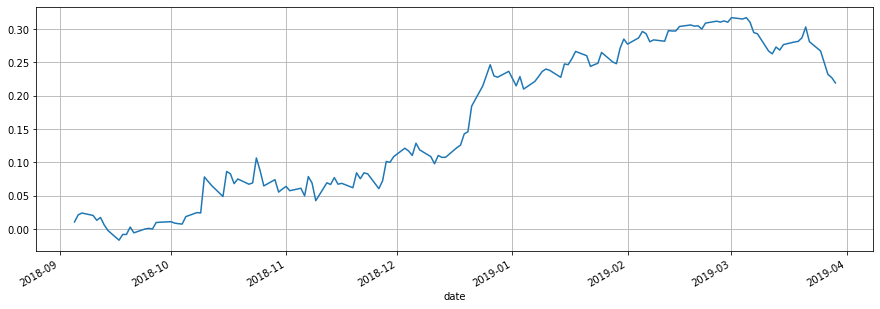

In [781]:
np.log(out[1]+1).cumsum().plot(figsize=(15, 5), grid=True);

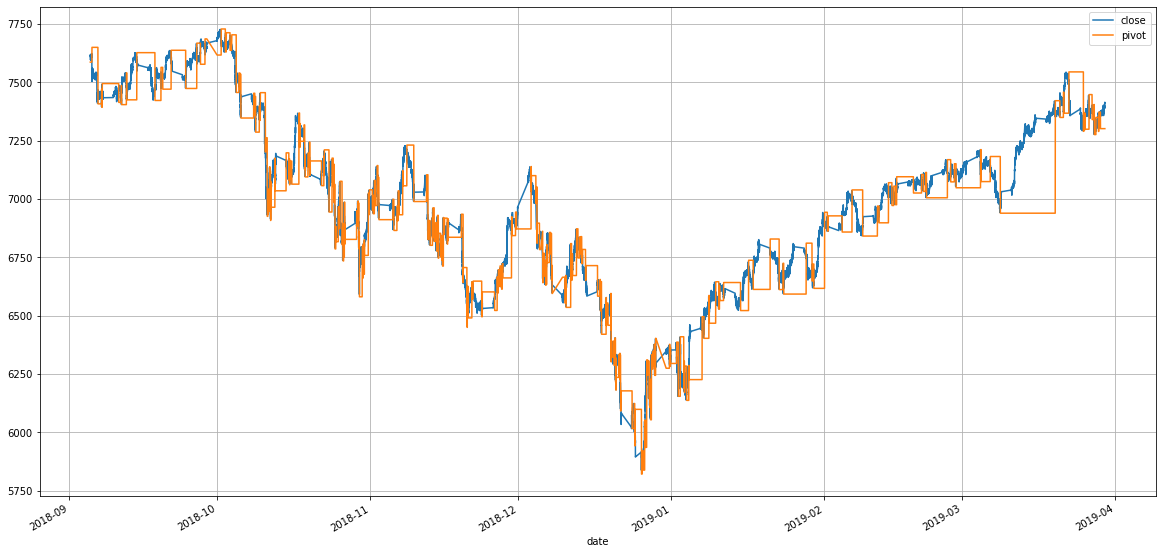

In [766]:
df7[['close', 'pivot']].plot(figsize=(20,10), grid=True);

### out of sample

In [767]:
df10 = get_data('NQ')
df10 = df10.loc['20190331': '20190930']
df10[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing(df10, 60, 1)
df10 = df10.iloc[3000:]
out = sim(df10['close'], df10['signal'])
out[0]

Annual return                -0.0569345
Cumulative returns           -0.0293361
Annual volatility              0.196116
Sharpe ratio                  -0.201587
Calmar ratio                  -0.321147
Stability                     0.0048957
Max drawdown                  -0.177285
Omega ratio                    0.965129
Sortino ratio                 -0.283757
Skew                          0.0787731
Kurtosis                        2.43782
Tail ratio                     0.889029
Daily value at risk          -0.0248652
Win percent                    0.576923
Average gain                     117.25
Average loss                   -181.886
Avg gain/loss ratio            0.644633
Position EV                    -9.30769
Positions per day              0.203125
Days per position               4.92308
Actual avg. duration    6 days 22:52:00
Days                                128
Positions                            26
Trades                               51
Monthly EV                     -39.7031


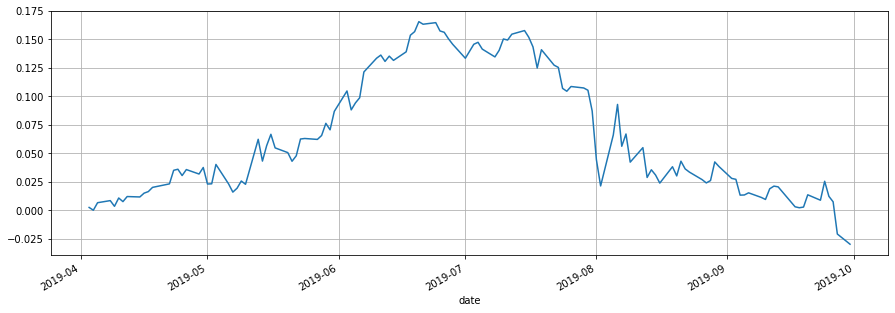

In [768]:
np.log(out[1]+1).cumsum().plot(figsize=(15, 5), grid=True);

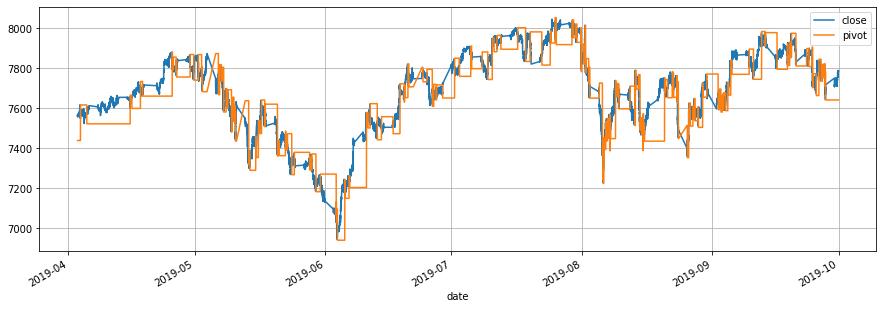

In [770]:
df10[['close', 'pivot']].plot(figsize=(15,5), grid=True);

# Single Swing with ATR Filter

In [910]:
df8 = df.copy()
df8['atr'] = (get_ATR(df8[['high', 'low', 'close']], 3000) * 10)
df8[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing(df8, df8['atr'], 1)
df8 = df8[3000:]

In [911]:
out = sim(df8['close'], df8['signal'])
out[0]

Annual return                  0.296416
Cumulative returns             0.162305
Annual volatility              0.226706
Sharpe ratio                    1.25829
Calmar ratio                    2.45497
Stability                      0.681878
Max drawdown                  -0.120741
Omega ratio                     1.23948
Sortino ratio                    1.8702
Skew                         -0.0927017
Kurtosis                        1.36379
Tail ratio                      1.14764
Daily value at risk          -0.0274302
Win percent                    0.412844
Average gain                      107.7
Average loss                   -58.8672
Avg gain/loss ratio             1.82954
Position EV                     9.89908
Positions per day              0.746575
Days per position               1.33945
Actual avg. duration    1 days 21:16:00
Days                                146
Positions                           109
Trades                              217
Monthly EV                      155.199


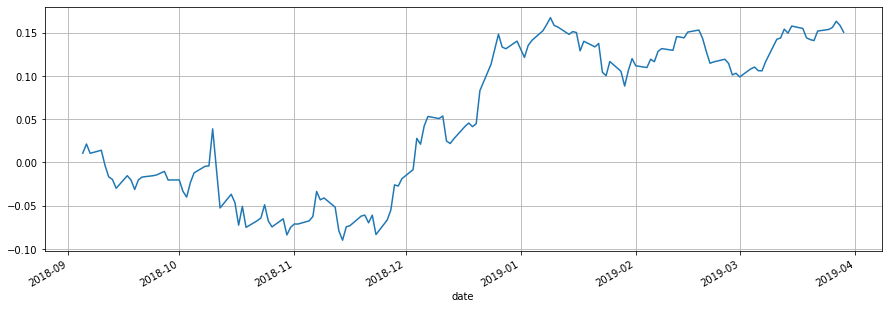

In [912]:
np.log(out[1]+1).cumsum().plot(figsize=(15, 5), grid=True);

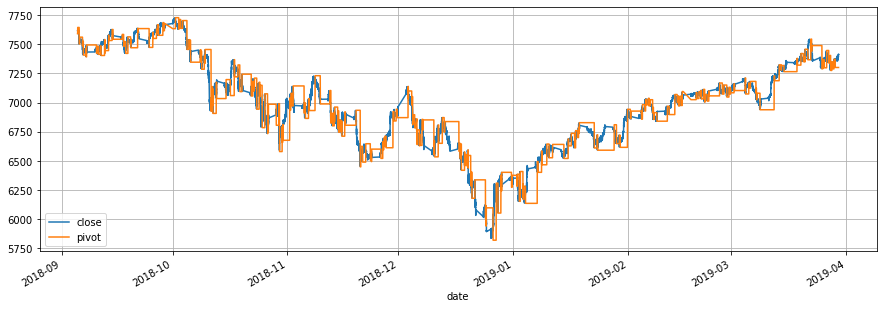

In [882]:
df8[['close', 'pivot']].plot(figsize=(15,5), grid=True);

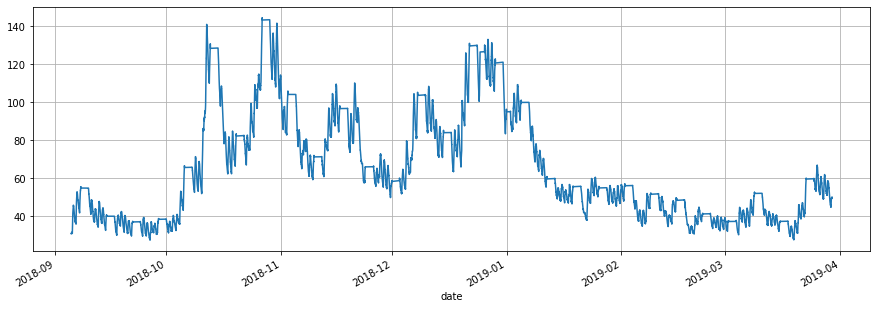

In [883]:
df8['atr'].plot(figsize=(15,5), grid=True);

### out of sample

In [905]:
df9 = get_data('NQ')
df9 = df9.loc['20190331': '20190930']
df9['atr'] = get_ATR(df9[['high', 'low', 'close']], 1500) * 20
df9[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing(df9, df9['atr'], 1)
df9 = df9.iloc[3000:]
out = sim(df9['close'], df9['signal'])
out[0]

Annual return                  -0.13299
Cumulative returns           -0.0699204
Annual volatility               0.18234
Sharpe ratio                  -0.692314
Calmar ratio                  -0.925474
Stability                      0.353492
Max drawdown                    -0.1437
Omega ratio                    0.883766
Sortino ratio                  -1.01795
Skew                           0.643915
Kurtosis                        3.60591
Tail ratio                      1.05722
Daily value at risk          -0.0234737
Win percent                    0.344828
Average gain                      125.3
Average loss                   -93.2237
Avg gain/loss ratio             1.34408
Position EV                    -17.8707
Positions per day              0.226562
Days per position               4.41379
Actual avg. duration    6 days 05:36:00
Days                                128
Positions                            29
Trades                               57
Monthly EV                     -85.0254


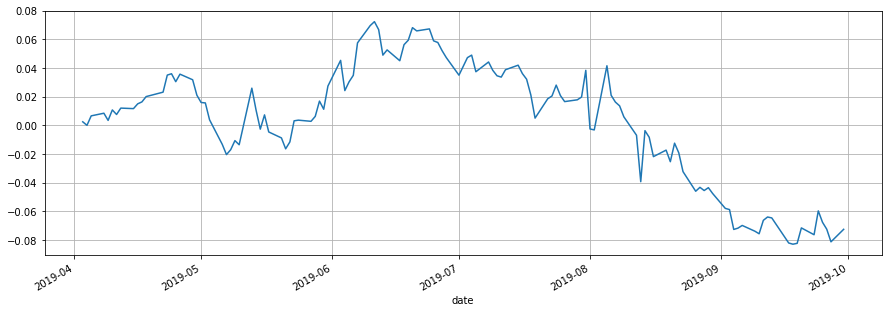

In [906]:
np.log(out[1]+1).cumsum().plot(figsize=(15, 5), grid=True);

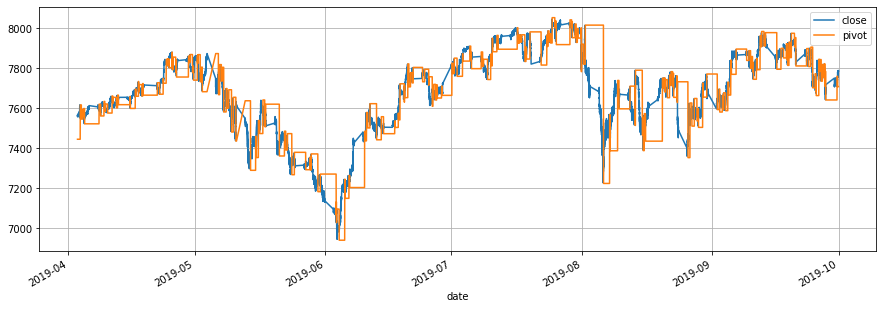

In [907]:
df9[['close', 'pivot']].plot(figsize=(15,5), grid=True);

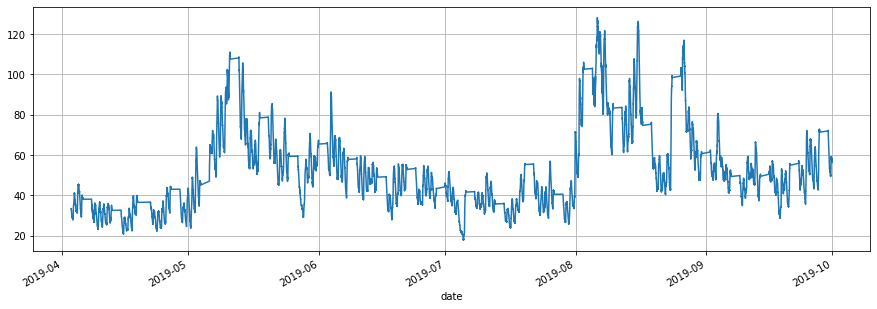

In [908]:
df9['atr'].plot(figsize=(15,5), grid=True);

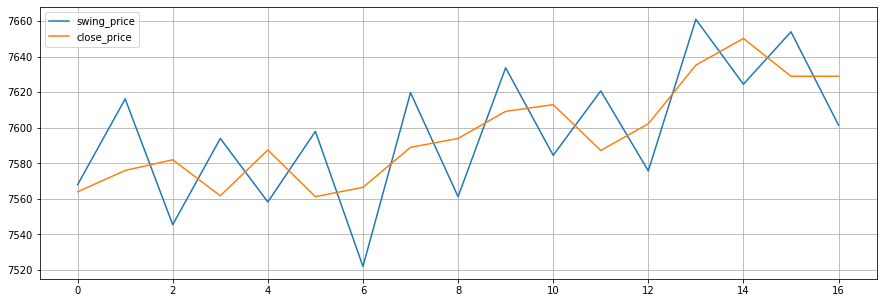

In [909]:
swing_chart_data(df9[:10000]).plot(figsize=(15,5), grid=True);

In [741]:
df9

,open,high,low,close,volume,average,barCount,atr,swing,extreme,pivot,signal,max_list,min_list
date,,,,,,,,,,,,,,
2019-04-03 04:30:00,7562.50,7564.00,7562.00,7564.00,194,7562.900,97,16.689268,1.0,7568.00,7537.75,1.0,0.0,0.0
2019-04-03 04:31:00,7564.00,7564.50,7562.00,7562.25,148,7563.025,90,16.700548,1.0,7568.00,7537.75,1.0,0.0,0.0
2019-04-03 04:32:00,7562.25,7562.25,7560.25,7561.00,80,7561.175,51,16.705026,1.0,7568.00,7537.75,1.0,0.0,0.0
2019-04-03 04:33:00,7560.75,7562.00,7560.75,7561.25,99,7561.300,54,16.699319,1.0,7568.00,7537.75,1.0,0.0,0.0
2019-04-03 04:34:00,7561.25,7562.00,7561.00,7561.25,39,7561.475,24,16.690227,1.0,7568.00,7537.75,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30 22:55:00,7787.25,7788.00,7786.00,7787.75,76,7787.375,55,28.524794,1.0,7788.75,7751.25,-1.0,0.0,0.0
2019-09-30 22:56:00,7788.00,7788.25,7784.25,7785.00,122,7786.075,69,28.540084,1.0,7788.75,7751.25,-1.0,0.0,0.0
2019-09-30 22:57:00,7785.00,7787.25,7785.00,7786.75,59,7786.225,42,28.532036,1.0,7788.75,7751.25,-1.0,0.0,0.0


In [841]:
a = pd.DataFrame()
a['x'] = np.linspace(0, 8, 100)
a['y'] = np.log(a['x'] * 2)
a['y1'] = 2*a['x'] ** 2  + 40
a['y2'] = a['x'] **1.5
a.set_index('x', inplace=True)
a

,y,y1,y2
x,,,
0.000000,-inf,40.000000,0.000000
0.080808,-1.822531,40.013060,0.022971
0.161616,-1.129384,40.052240,0.064972
0.242424,-0.723919,40.117539,0.119361
0.323232,-0.436237,40.208958,0.183769
...,...,...,...
7.676768,2.731346,157.865524,21.270005
7.757576,2.741817,160.359963,21.606730
7.838384,2.752180,162.880522,21.945212


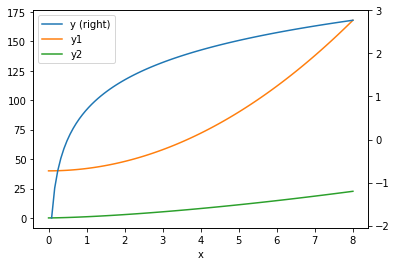

In [842]:
a.plot(secondary_y='y');

In [69]:
2**1.5

2.8284271247461903

In [784]:
dfx = df.copy()

In [785]:
dfx['atr'] = get_ATR(dfx[['high', 'low', 'close']], 4200)

In [786]:
dfx.describe()

,open,high,low,close,volume,average,barCount,atr
count,200265.000000,200265.000000,200265.00000,200265.000000,200265.000000,200265.000000,200265.000000,200265.000000
mean,7010.217318,7011.766015,7008.67134,7010.216607,384.919102,7010.219197,215.710534,3.081535
std,386.401525,385.987420,386.80897,386.399296,652.783111,386.397425,349.190697,1.278133
min,5835.500000,5842.000000,5820.50000,5837.000000,0.000000,5833.400000,0.000000,0.690570
25%,6726.250000,6727.750000,6724.50000,6726.250000,43.000000,6726.225000,30.000000,1.980911
50%,7023.500000,7025.250000,7022.00000,7023.500000,107.000000,7023.700000,69.000000,2.693604
75%,7334.250000,7335.500000,7333.00000,7334.250000,424.000000,7334.400000,236.000000,4.038665
max,7727.250000,7728.750000,7724.75000,7727.000000,17549.000000,7726.375000,6643.000000,6.736251


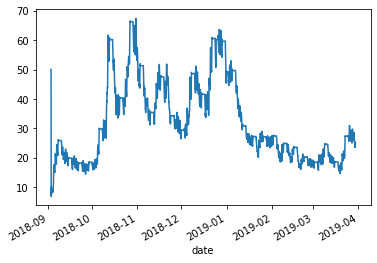

In [792]:
(10*dfx['atr']).plot();

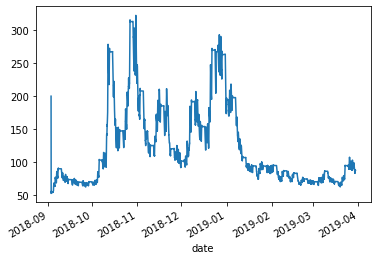

In [788]:
(6*dfx['atr']**2+50).plot();

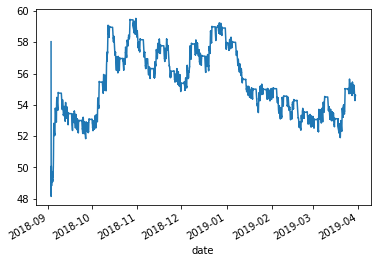

In [797]:
((np.log(dfx['atr'])+10) * 5).plot();